In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ephem
from datetime import datetime
import math

In [2]:
import torch
device = torch.device("cuda")
torch.tensor([1.]).to(device)

tensor([1.], device='cuda:0')

In [3]:
#!pip install gymnasium
#!pip install stable-baselines3[extra]

In [4]:
import gymnasium as gym
from gymnasium import spaces

from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import A2C,DQN,PPO
from stable_baselines3.common.env_util import make_vec_env

import torch
import torch.nn as nn

import os

## Data preprocess

In [5]:
train = pd.read_csv('Useful data/train_final2.csv')
ctrl = pd.read_csv('Useful data/ctrl_final2.csv')

train = pd.DataFrame(train)
ctrl = pd.DataFrame(ctrl)


In [6]:
train['Date'] = pd.to_datetime(train['Date'])
ctrl['Date'] = pd.to_datetime(ctrl['Date'])

train['Time'] = pd.to_datetime(train['Time'])
ctrl['Time'] = pd.to_datetime(ctrl['Time'])


C:\Users\aleza\AppData\Local\Temp\ipykernel_36432\1618736993.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train['Time'] = pd.to_datetime(train['Time'])
C:\Users\aleza\AppData\Local\Temp\ipykernel_36432\1618736993.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ctrl['Time'] = pd.to_datetime(ctrl['Time'])


In [7]:
filtered_train = train.copy()
filtered_train['Minutes'] = filtered_train['Time'].dt.minute

# Filter observations where minutes are multiples of 10
filtered_train = filtered_train[filtered_train['Minutes'] % 10 == 0]

In [8]:
temps = filtered_train[['T - Drainage chute - Test Dept.',
       'T- Inlet behind conditioner', 'T - Inlet gap for door - Test Dept.',
       'T - Inlet gap outside wall - Test Dept.', 'T- Inlet for conditioner',
       'T - Macro front compartment - Test Dept.',
       'T - Macro rear compartment - Test Dept.', 'Current temperature']]

train['Inside temperature'] = train['Current temperature']
ctrl['Inside temperature'] = ctrl['Current temperature']

meantemp_train = (train['T - Drainage chute - Test Dept.'])
meantemp_ctrl = (ctrl['T - Drainage chute - Control Dept.'])

train['meandiff'] = meantemp_train.shift(-1) - meantemp_train
ctrl['meandiff'] = meantemp_ctrl.shift(-1) - meantemp_ctrl

train['Minute'] = train['Time'].dt.minute 
ctrl['Minute'] = ctrl['Time'].dt.minute 

for i in range(0,len(train)):
    if((train.loc[i,'Minute'] % 10) != 0):
        train.loc[i,'Inside temperature'] = train.loc[i-1,'Inside temperature'] + train.loc[i,'meandiff']

for i in range(0,len(ctrl)):
    if((ctrl.loc[i,'Minute'] % 10) != 0):
        ctrl.loc[i,'Inside temperature'] = ctrl.loc[i-1,'Inside temperature'] + ctrl.loc[i,'meandiff']


# Estimating parameters for the balance equation

## $\text{Balance equation:} \frac{\partial T_i}{{\partial t}} = \frac{1}{C} * (Q_{\text{gain}} - Q_{loss})$

$\frac{\partial T_i}{{\partial t}}$ is the rate of temperature change (°C/s or °C/min).

C is the thermal capacitance of the pig house (expressed in J/°C or J/K). $C = c_p \cdot m$, where $c_p$ is the specfic heat capacity of the air in the envelope and $m$ is the mass of Air in the building. $m$ can be espressed as $V \cdot \rho_a$ where $V$ is the volume of the building and $\rho_a$ is the air density.

$Q_{\text{gain}}$ represents the total heat input into the pig house from various sources (Heat gain form pigs, floor heating system, heating exchanger, solar radiation)

$Q_{\text{loss}}$ represents the total heat loss from the pig house (ventilation system, building envelope).

This leads to the equation:

### $\rho_a \cdot V \cdot c_p \frac{\partial T_i}{{\partial t}} = Q_h + Q_{fh} + Q_r + Q_p + Q_v + Q_e$

 $T_{i+1} = T_i + \frac{\partial T_i}{{\partial t}} = T_i + \frac{Q_h + Q_{fh} + Q_r + Q_p + Q_v + Q_e}{\rho_a \cdot V \cdot c_p}$


## 1. first half of the equation

The air density $\rho$ can be calculated using the following function:

\begin{equation}
\rho = \frac{{P_{\text{dry\_air}}}}{{R_{\text{dry\_air}} \times T}}
\end{equation}

where:
\begin{align*}
R_{\text{dry\_air}} &= 287.05 \, \text{J/kg K} \\
P_{\text{atm}} &= 101325 \, \text{Pa}
\end{align*}

The vapor pressure of water vapor $e$ is calculated using:

\begin{equation}
e = 6.112 \times \exp\left(\frac{{17.67 \times T_i}}{{T_i + 243.5}}\right)
\end{equation}

The partial pressure of dry air $P_{\text{dry\_air}}$ can be obtained as:

\begin{equation}
P_{\text{dry\_air}} = P_{\text{atm}} - e
\end{equation}

Finally, substituting $P_{\text{dry\_air}}$ and $T$ into Equation (1), we get:

\begin{equation}
\rho = \frac{{P_{\text{atm}} - e}}{{R_{\text{dry\_air}} \times (T_i + 273.15)}}
\end{equation}



## Air specific heat capacity

$C_{pa} = f_d \times C_{pd} + f_v \times C_{pv}$

$C_{pa}$: Specific heat capacity of moist air (J/(kg·K)). 

$f_d$: Fraction of dry air in the air mixture 

$C_{pd}$: Specific heat capacity of dry air at constant pressure (J/(kg·K)). It represents the amount of heat required to raise the temperature of dry air by one degree Celsius at constant pressure. 

$f_v$: Fraction of water vapor in the air mixture. It represents the proportion of water vapor in the total air mixture. 

$C_{pv}$: Specific heat capacity of water vapor at constant pressure (J/(kg·K)). 


## Volume $9.69 \cdot 31 \cdot 3 = 901.17 m^3$

# 2. $Q_r$: heat gain in unit time from Solar radiation

## $Q_r = I_d \cdot A \cdot \pi_r$

where:
- $I_d = \text{Solar Radiation  } \frac{W}{m^2}$
- $A = \text{Area of the envelope surface that receives solar radiation  } m^2$
- $\pi_r = \text{envelope material transmission coefficient}$


## Solar irradiance

$I = I_0 * \cos{\theta}$

$I$: Solar irradiance on a flat surface (semplification, do not know the shape of the roof)

$I_o$: The average solar irradiance outside Earth's atmosphere, approximately 1361 W/m^2

$\theta$: Solar zenith angle, the angle between the Sun and the vertical direction. Can be estimated using the latitude and the time of the day :D

# $Q_v$: Heat loss for the ventilation system

$Q_v = \rho_a \cdot cp \cdot L_w \cdot (T_i - T_{f})$

where:
- $\rho_a$: Density of air (in kilograms per cubic meter).
- $c_p$: Specific heat capacity of air (in joules per kilogram per degree Celsius).
- $L_w$: Ventilation air flow rate (in cubic meters per second).
- $T_i$: Indoor air temperature (in degrees Celsius or Fahrenheit).
- $T_f$: Fresh air temperature (I know the temperature at the fan).


According to Andrè the ventilation is 25 m^3/h per pig, which would mean 300 m^3/s since there are 700 pigs. It sounds a bit unrealistic to me, but I define (temporary) $L_w = \frac{\text{Current ventilation}}{100}\cdot 300 = \text{Current ventilation} \cdot 3$

# 4. $Q_e$: Heat loss from envelope (conduction)

## Heat transfer process: $Q_e = k \frac{(T_o-T_i)A_c}{L}$

where:
- $k =  \text{Material specific heat transfer coefficient}$ (unknown)
- $L =  \text{Wall thickness}$ (unknown)
- $T_i =  \text{Inside temperature}$
- $T_o =  \text{Outside temperature}$
- $A_c =  \text{Envelope surface}$

# $Q_{fh}$: heat gain from floor heating
$Q_f = S_g \cdot h_g \cdot (T_i - T_p)$

$S_g$: floor surface

$h_g$: floor specific heat exchange coefficient (THIS APPARENTLY CANNOT BE ESTIMATED)

$T_p$: Floor temperature

The floor temperature is kept constant at 29.5°C


I create a variable containing the floor temperature at each time step

In [9]:
train['floor_temp'] = 29.5
ctrl['floor_temp'] = 29.5

# $Q_p$: Heat gain from pig skin surface


### starting weight: 7.25 Kg
### growth: 0.42 Kg/day

In [13]:
train_round_1 = train[train['Round'] == 1]
unique_days_1_train = train_round_1['Date'].dt.date.unique()

train_round_2 = train[train['Round'] == 2]
unique_days_2_train = train_round_2['Date'].dt.date.unique()

train_round_3 = train[train['Round'] == 3]
unique_days_3_train = train_round_3['Date'].dt.date.unique()

unique_days_train = np.concatenate((unique_days_1_train, unique_days_2_train, unique_days_3_train))


ctrl_round_1 = ctrl[ctrl['Round'] == 1]
unique_days_1_ctrl = ctrl_round_1['Date'].dt.date.unique()

ctrl_round_2 = ctrl[ctrl['Round'] == 2]
unique_days_2_ctrl = ctrl_round_2['Date'].dt.date.unique()

ctrl_round_3 = ctrl[ctrl['Round'] == 3]
unique_days_3_ctrl = ctrl_round_3['Date'].dt.date.unique()

unique_days_ctrl = np.concatenate((unique_days_1_ctrl, unique_days_2_ctrl, unique_days_3_ctrl))

In [14]:
def Qpig(day):
    weight = 7.25 + 0.42*day
    r = 1  #Assuming all metabolizable energy is utilized (no inefficiency)
    
    MEm = 5.09 * weight**0.75
    
    kY = 0.47 + 0.003 * weight
    
    ME = r * MEm
    
    Q_total = MEm + (1 - kY) * (ME - MEm)
    
    return (Q_total)

Qpigs_1 = [Qpig(i) for i in range(len(unique_days_1_train))]
Qpigs_2 = [Qpig(i) for i in range(len(unique_days_2_train))]
Qpigs_3 = [Qpig(i) for i in range(len(unique_days_3_train))]

Q_pig = np.concatenate((Qpigs_1, Qpigs_2, Qpigs_3))

# Create a dictionary with the days and floor temperatures
Qpigsdic = {'Date': unique_days_train, 'Qpig': Q_pig}

# Convert the dictionary to a DataFrame
Qpigsdic = pd.DataFrame(Qpigsdic)

Qpigsdic['Date'] = pd.to_datetime(Qpigsdic['Date'])
train = pd.merge(train, Qpigsdic, on='Date')


Qpigs_1 = [Qpig(i) for i in range(len(unique_days_1_ctrl))]
Qpigs_2 = [Qpig(i) for i in range(len(unique_days_2_ctrl))]
Qpigs_3 = [Qpig(i) for i in range(len(unique_days_3_ctrl))]

Q_pig = np.concatenate((Qpigs_1, Qpigs_2, Qpigs_3))

# Create a dictionary with the days and floor temperatures
Qpigsdic = {'Date': unique_days_ctrl, 'Qpig': Q_pig}

# Convert the dictionary to a DataFrame
Qpigsdic = pd.DataFrame(Qpigsdic)

Qpigsdic['Date'] = pd.to_datetime(Qpigsdic['Date'])
ctrl = pd.merge(ctrl, Qpigsdic, on='Date')

Within the CIGR report (2002) a correction is made for heat production depending on the indoor temperature. Forevery degree Celsius above 20o heat production is lowered with 1.2% and for every degree Celsius below 20o heatproduction is raised with 1.2%. This linear correction ignores the existence of a thermo-neutral zone, but as is shown inthe report the error assuming linearity is rather small and estimates were even better than in previous reports in which thethermo-neutral zone was incorporated 

(9) (PDF) Heat and moisture production in growing-finishing pigs and broilers. Available from: https://www.researchgate.net/publication/332935867_Heat_and_moisture_production_in_growing-finishing_pigs_and_broilers [accessed May 03 2024].

# 3. $Q_h$: heat produced by the heating system (Heat exchanger).





When the outside temperature is below 8°, air that passes through the heat exchanger gets heated with water.

## $Q = U \cdot A \cdot (T_{\text{gw}} − T_{\text{air}}) \cdot H(T_{\text{o}})$

Where:
\begin{align*}
\textstyle H(T_o) = \begin{cases}
      0 \text{ \ \  \  \  when $T_o > 8$} \\
      1 \text{ \ \  \  \  when $T_o \leq 8$}
    \end{cases}
\end{align*}

$T_{\text{air}}$ is the temperature th the inlet for the conditioner. for simplicity $T_{\text{air}} = T_o$.

U and A are the heat transfer coefficient and surface of the exchanger. both unknow, so I will estimate them as a sigle constant $k_h = U \cdot A$

# Define the function for the temperature change rate :D

In [15]:
# volume
V = 9.69*31*3

# Constants for air density
R_dry_air = 287.05  # Specific gas constant for dry air (J/kg K)
P_atm = 101325  

# Constants for specific heat capacity
C_pd_dry_air = 1005  # Specific heat capacity of dry air at constant pressure (J/(kg·K))
C_pv_water_vapor = 1860  # Specific heat capacity of water vapor at constant pressure (J/(kg·K))

#Constant for Qe
Ac = 31 * 3 * 2 + 9.69*3*2 + 31*9.69

# Constants for Qfh
S_g = 31*9.69


In [16]:
def calculate_air_density(relative_humidity, ti):
    temperature_K = ti + 273.15  # Convert temperature to Kelvin

    # Convert relative humidity from percentage to fraction
    relative_humidity_fraction = relative_humidity / 100

    # Calculate vapor pressure of water vapor (Pa)
    e = 6.112 * math.e**((17.67 * ti) / (ti + 243.5)) * relative_humidity_fraction

    # Calculate partial pressure of dry air (Pa)
    P_dry_air = P_atm - e

    # Calculate air density (kg/m³)
    air_density = P_dry_air / (R_dry_air * temperature_K)

    return air_density

# Function to calculate specific heat capacity of moist air
def calculate_specific_heat_capacity(humidity):
    # Mass fraction of dry air and water vapor
    relative_humidity = humidity / 100
    f_dry_air = 1 - relative_humidity
    f_water_vapor = relative_humidity

    # Calculate specific heat capacity of moist air
    C_p_moist_air = f_dry_air * C_pd_dry_air + f_water_vapor * C_pv_water_vapor

    return C_p_moist_air

def Qr(Id_areahit, pr):
    return Id_areahit * pr

def Qv(rh, Cv, Ct, Tf): #Ct is Current temperature
    air_dens = calculate_air_density(rh, Ct)
    heat_cap = calculate_specific_heat_capacity(rh)
    return (air_dens * heat_cap * Cv/100 * (25*700/3600) * (Tf - Ct))


def Qe(Ti, To, ks_L):
    return(ks_L * Ac * (To - Ti))


def Qfh(Ti,tp,h_g):
    return (S_g * h_g * (tp - Ti))


def Qp(qpig, ti, n = 700):
    qp = qpig * n
    return qp + qp*(-0.012*(ti-20))

def Qh_(heat_cap, k, To):
    if To > 8:
        val = 0
    elif To <= 8:
        val = heat_cap*k*(10 - To)
    
    return val

def Qh(heat_cap, k, To):
    heat_transfer_rate = torch.zeros(To.shape).to(To.device)
    heat_transfer_rate = torch.where((To <= 8), heat_cap*k * (10 - To), heat_transfer_rate)
    return heat_transfer_rate

def Qh2_(k1, To):
    if To > 15:
        val = 0
    elif To <= 15:
        val = 100
    else:
        val = -100/3*To+500
    
    return k1 * val

def Qh2(k1, To):
    heat_transfer_rate = torch.zeros(To.shape).to(To.device)
    heat_transfer_rate = torch.where((To <= 15) & (To > 12), k1 * (-100/3*To  +500), heat_transfer_rate)
    heat_transfer_rate = torch.where((To <= 12), k1 * 100, heat_transfer_rate)

    return heat_transfer_rate


def change_rate(ti, to, tp, Ct, rh, Id_areahit, Cv, qpig, k, k1, ks_L, h_g, pr, kv):
    air_dens = calculate_air_density(rh, ti)
    heat_cap = calculate_specific_heat_capacity(rh)
    qr = Qr(Id_areahit, pr)
    qh = Qh_(heat_cap, k, to)
    qh2 = Qh2_(k1, to)
    qe = Qe(ti, to, ks_L)
    qv = Qv(rh, Cv, Ct, to) * kv
    qfh = Qfh(ti,tp,h_g)
    qp = Qp(qpig,ti)
    increment = (qh + qh2 + qe + qv + qfh + qp + qr) / (air_dens * heat_cap * V)
    return increment

def change_rate_faster(ti, to, tp, Ct, rh, Cv, BSA, ks_L, h_g, qh, qh2, qr, heat_cap, kv):
    air_dens = calculate_air_density(rh, ti)
    qe = Qe(ti, to, ks_L)
    qv = Qv(rh, Cv, Ct, to) * kv
    qfh = Qfh(ti,tp,h_g)
    qp = Qp(BSA,ti)
    increment = (qh + qh2 + qe + qv + qfh + qp + qr) / (air_dens * heat_cap * V)
    return increment

def rk4_faster(ti, to, tp, Ct, rh, Cv, BSA, ks_L, h_g, qh, qh2, qr, heat_cap, kv, h = 300):
    inc1 = change_rate_faster(ti, to, tp, Ct, rh, Cv, BSA, ks_L, h_g, qh, qh2, qr, heat_cap, kv)
    inc2 = change_rate_faster(ti + inc1 * h/2, to, tp, Ct, rh, Cv, BSA, ks_L, h_g, qh, qh2, qr, heat_cap, kv)
    inc3 = change_rate_faster(ti + inc2* h/2, to, tp, Ct, rh, Cv, BSA, ks_L, h_g, qh, qh2, qr, heat_cap, kv)
    inc4 = change_rate_faster(ti + h*inc3, to, tp, Ct, rh, Cv, BSA, ks_L, h_g, qh, qh2, qr, heat_cap, kv)

    return ti + (inc1 + 2*inc2 + 2*inc3 + inc4)/6


def rk42_faster(ti, to, tp, Ct, rh, Id_areahit, Cv, BSA, k, k1, ks_L, h_g, pr, kv, hi=150):
    heat_cap = calculate_specific_heat_capacity(rh)
    qr = Qr(Id_areahit, pr)
    qh = Qh(heat_cap, k, to)
    qh2 = Qh2(k1, to)
    steps = int(300/hi)
    for i in range(1,steps):
        ti = rk4_faster(ti, to, tp, Ct, rh, Cv, BSA, ks_L, h_g, qh, qh2, qr, heat_cap, kv, hi)
    return ti



def rk42_faster2(ti, to, tp, Ct, rh, Id_areahit, Cv, BSA, k, k1, ks_L, h_g, pr, kv, hi=150):
    heat_cap = calculate_specific_heat_capacity(rh)
    qr = Qr(Id_areahit, pr)
    qh = Qh_(heat_cap, k, to)
    qh2 = Qh2_(k1, to)
    steps = int(300/hi)
    for i in range(1,steps):
        ti = rk4_faster(ti, to, tp, Ct, rh, Cv, BSA, ks_L, h_g, qh, qh2, qr, heat_cap, kv, hi)
    return ti

# Optimal constants

In [17]:
train['Next temperature'] = train['T - Drainage chute - Test Dept.'].shift(-1)
ctrl['Next temperature'] = ctrl['T - Drainage chute - Control Dept.'].shift(-1)

In [18]:
ctrl.drop(ctrl.index[11942:13580], inplace=True)
ctrl = ctrl.dropna().reset_index(drop=True)

In [19]:
train['Time'] = train['Time'].dt.time
ctrl['Time'] = ctrl['Time'].dt.time

In [20]:
train.drop_duplicates(subset=['Date', 'Time'], inplace=True)
train.reset_index(drop=True, inplace=True)

train['nextstep'] = None

time_string = train['Time'].astype(str)
for i in range(len(train)-1):
    time_plus = time_string[i+1]
    time = time_string[i]

    time_plus = datetime.strptime(time_plus, '%H:%M:%S')
    time = datetime.strptime(time, '%H:%M:%S')

    diff = time_plus - time

    if diff.seconds == 300:
        train.loc[i,'nextstep'] = 1
    else:
        train.loc[i,'nextstep'] = 0


ctrl.drop_duplicates(subset=['Date', 'Time'], inplace=True)
ctrl.reset_index(drop=True, inplace=True)

ctrl['nextstep'] = None

time_string = ctrl['Time'].astype(str)
for i in range(len(ctrl)-1):
    time_plus = time_string[i+1]
    time = time_string[i]

    time_plus = datetime.strptime(time_plus, '%H:%M:%S')
    time = datetime.strptime(time, '%H:%M:%S')

    diff = time_plus - time

    if diff.seconds == 300:
        ctrl.loc[i,'nextstep'] = 1
    else:
        ctrl.loc[i,'nextstep'] = 0

In [21]:
df1 = train.dropna().reset_index(drop=True)
df2 = ctrl.dropna().reset_index(drop=True)

df1["department"] = "Test"
df2["department"] = "Control"

df = df1
#df = pd.concat([df1, df2])
#df = df[df['Next temperature']!= 0]
#df = df[df['Round'].isin([2, 3])].reset_index(drop=True)

# Gradient descent: Batches by day <3


In [22]:
# Assuming df is your DataFrame and it has 'Date', 'time', and 'department' columns
#df['Date'] = pd.to_datetime(df['Date'])
#df['Time'] = pd.to_timedelta(df['Time'])

# Sort the DataFrame by date, time, and department
df = df.sort_values(by=['Date', 'Time', 'department'])

In [23]:
df['nextstep'] = pd.to_numeric(df['nextstep'], errors='coerce')

In [ ]:
import torch
import random
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = torch.device('cuda')
torch.manual_seed(123)


Ti_tensor = torch.tensor(df['Inside temperature'].values, dtype=torch.float32).unsqueeze(1).to(device)
To_tensor = torch.tensor(df['T- Inlet behind conditioner'].values, dtype=torch.float32).unsqueeze(1).to(device)
Tp_tensor = torch.tensor(df['floor_temp'].values, dtype=torch.float32).unsqueeze(1).to(device)
Ct_tensor = torch.tensor(df['Inside temperature'].values, dtype=torch.float32).unsqueeze(1).to(device)
rh_tensor = torch.tensor(df['humidity'].values, dtype=torch.float32).unsqueeze(1).to(device)
Id_areahit_tensor = torch.tensor(df['Id_areahit'].values, dtype=torch.float32).unsqueeze(1).to(device)
Cv_tensor = torch.tensor(df['Current ventilation'].values, dtype=torch.float32).unsqueeze(1).to(device)
BSA_tensor = torch.tensor(df['Qpig'].values, dtype=torch.float32).unsqueeze(1).to(device)
nextemp_tensor = torch.tensor(df['Next temperature'].values, dtype=torch.float32).unsqueeze(1).to(device)
nextstep_tensor = torch.tensor(df['nextstep'].values, dtype=torch.float32).unsqueeze(1).to(device)
ricky = torch.concat([Ti_tensor,To_tensor,Tp_tensor, Ct_tensor, rh_tensor,Id_areahit_tensor,Cv_tensor,BSA_tensor,nextemp_tensor, nextstep_tensor], dim=1)


batch_size = len(df)
batches = len(df)//batch_size
last_batch_size = len(df)%batch_size
batches = batches + (last_batch_size > 0)


# Define the objective function using PyTorch
def objective_torch(batch):
    k, k1, ks_L, h_g, pr = params
    kv = 1
    t = torch.zeros(batch.shape[0]).to(device)
    t[0] = batch[0,0]
    for i in range(batch.shape[0]-1):
        if i % 10000 == 0:
            print(f"[Iteration: {i+1}]")
        if(batch[i,9] == 1):
            t[i+1] = rk42_faster(t[i], batch[i,1], 29.5, batch[i,3], batch[i,4], batch[i,5], batch[i,6], batch[i,7], torch.abs(k), torch.abs(k1), torch.abs(ks_L), torch.abs(h_g), torch.abs(pr), kv, hi=150)
        else:
            t[i+1] = batch[i+1,0]
    return torch.mean(torch.abs(t - batch[:,8]))

# Initial guess for the parameters
params = torch.randn(5, dtype=torch.float32, requires_grad=True, device=device)
# Create an optimizer (using stochastic gradient descent)
optimizer = Adam([params], lr = 0.3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=10) #was 10

# Perform optimization
for epoch in range(1000):  # Adjust the number of epochs as needed
    # p = np.random.permutation(ricky.size(0))
    # ricky = ricky[p]
    error_ep = 0
    for i in range(batches):
        batch = ricky[i*batch_size:(i+1)*batch_size]
        optimizer.zero_grad()
        loss = objective_torch(batch)
        loss.backward()
        optimizer.step()
        error_ep += loss.item()
        if i % 100 == 0:
            print(f"[{i+1}/{batches}] Loss: {error_ep/(i+1)}")
    print("Current values of k, k1, ks_L, h_g, pr:", params)
    print(f"[{epoch+1}/{1000}] Loss: {error_ep/batches}")


# Extract the optimal values of the parameters
optimal_params = params.detach().cpu().numpy()

print("Optimal values of k, k1, ks_L, h_g, pr:", optimal_params)


In [33]:
#After 100 iterations: loss 0.81 (random start) first lr = 3
4.78726292e+00, 1.58387823e+01, 8.12032819e-01, 1.45196295e+01, 9.16540902e-03

#after 140 iterations: loss 0.608 (random start) first lr = 0.3
4.0490e+00, 2.1593e+01, 2.1263e+00, 2.2735e+01, 1.9389e-02

#after 220 iterations: loss 0.52 (random start) first lr = 0.3
print(3.8775e+00,  3.6609e+01,  4.3030e+00,  3.3426e+01, 2.7303e-02)

3.8775 36.609 4.303 33.426 0.027303


In [25]:
def trend_plotter(df, k, k1, Ks_L, h_g, pr,kv, round=0):
    if round != 0:
        df = df[df['Round'] == round].reset_index(drop=True)
    df['newtemp'] = None
    df.loc[0,'newtemp'] = df.loc[0,'Inside temperature']

    for i in range(len(df)-1):
        if(df.loc[i,'nextstep'] == 1):
            df.loc[i+1,'newtemp'] = rk42_faster2(df.loc[i,'newtemp'], df.loc[i,'T- Inlet behind conditioner'], 29.5, df.loc[i,'newtemp'], df.loc[i,'humidity'], df.loc[i,'Id_areahit'], df.loc[i,'Current ventilation'], df.loc[i,'Qpig'],k, k1, Ks_L, h_g, pr,kv, hi=60)
        else:
            df.loc[i+1,'newtemp'] = df.loc[i+1,'Inside temperature']

    fg, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

    # Plot the first plot in the top-left position
    axes[0][0].plot(df['Inside temperature'], label='Actual temperature')
    axes[0][0].plot(df['newtemp'], label='Actual temperature')
    axes[0][0].set_xlabel('Index')
    axes[0][0].set_ylabel('Temperature')
    axes[0][0].set_title('Temperature Comparison')

    axes[0][1].plot(df[df['Round'] == 1]['Inside temperature'], label='Actual temperature')
    axes[0][1].plot(df[df['Round'] == 1]['newtemp'], label='Actual temperature')
    axes[0][1].set_xlabel('Index')
    axes[0][1].set_ylabel('Temperature')
    axes[0][1].set_title('Round 1 temperature Comparison')

    axes[1][0].plot(df[df['Round'] == 2]['Inside temperature'], label='Actual temperature')
    axes[1][0].plot(df[df['Round'] == 2]['newtemp'], label='Actual temperature')
    axes[1][0].set_xlabel('Index')
    axes[1][0].set_ylabel('Temperature')
    axes[1][0].set_title('Round 2 temperature Comparison')

    axes[1][1].plot(df[df['Round'] == 3]['Inside temperature'], label='Actual temperature')
    axes[1][1].plot(df[df['Round'] == 3]['newtemp'], label='Actual temperature')
    axes[1][1].set_xlabel('Index')
    axes[1][1].set_ylabel('Temperature')
    axes[1][1].set_title('Round 3 temperature Comparison')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

    print([np.mean(abs(df['newtemp']-df['Next temperature'])), np.var(df['newtemp']-df['Next temperature']), np.mean(df1['newtemp']-df1['Next temperature'])])

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def trend_plotter(df, k, k1, Ks_L, h_g, pr, kv, round=0):
    df1 = df.copy()
    df1['Date'] = pd.to_datetime(df1['Date'].astype(str) + ' ' + df1['Time'].astype(str))
    if round != 0:
        df1 = df1[df1['Round'] == round].reset_index(drop=True)
    df1['newtemp'] = None
    df1.loc[0, 'newtemp'] = df1.loc[0, 'Inside temperature']

    for i in range(len(df1) - 1):
        if df1.loc[i, 'nextstep'] == 1:
            df1.loc[i + 1, 'newtemp'] = rk42_faster2(df1.loc[i, 'newtemp'], df1.loc[i, 'T- Inlet behind conditioner'], 29.5, df1.loc[i, 'newtemp'], df1.loc[i, 'humidity'], df1.loc[i, 'Id_areahit'], df1.loc[i, 'Current ventilation'], df1.loc[i, 'Qpig'], k, k1, Ks_L, h_g, pr, kv, hi=60)
        else:
            df1.loc[i + 1, 'newtemp'] = df1.loc[i + 1, 'Inside temperature']

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))


    # Plot the first plot in the top-left position
    axes[0][0].plot(df1['Date'], df1['Inside temperature'], label='Actual temperature')
    axes[0][0].plot(df1['Date'], df1['newtemp'], label='Predicted temperature')
    axes[0][0].set_xlabel('Date')
    axes[0][0].set_ylabel('Temperature')
    axes[0][0].set_title('Temperature Comparison')

    axes[0][1].plot(df1[df1['Round'] == 1]['Date'], df1[df1['Round'] == 1]['Inside temperature'], label='Actual temperature')
    axes[0][1].plot(df1[df1['Round'] == 1]['Date'], df1[df1['Round'] == 1]['newtemp'], label='Predicted temperature')
    axes[0][1].set_xlabel('Date')
    axes[0][1].set_ylabel('Temperature')
    axes[0][1].set_title('Round 1 Temperature Comparison')

    axes[1][0].plot(df1[df1['Round'] == 2]['Date'], df1[df1['Round'] == 2]['Inside temperature'], label='Actual temperature')
    axes[1][0].plot(df1[df1['Round'] == 2]['Date'], df1[df1['Round'] == 2]['newtemp'], label='Predicted temperature')
    axes[1][0].set_xlabel('Date')
    axes[1][0].set_ylabel('Temperature')
    axes[1][0].set_title('Round 2 Temperature Comparison')

    axes[1][1].plot(df1[df1['Round'] == 3]['Date'], df1[df1['Round'] == 3]['Inside temperature'], label='Actual temperature')
    axes[1][1].plot(df1[df1['Round'] == 3]['Date'], df1[df1['Round'] == 3]['newtemp'], label='Predicted temperature')
    axes[1][1].set_xlabel('Date')
    axes[1][1].set_ylabel('Temperature')
    axes[1][1].set_title('Round 3 Temperature Comparison')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Print the mean absolute error and variance
    print([np.mean(abs(df1['newtemp'] - df1['Next temperature'])), np.var(df1['newtemp'] - df1['Next temperature']), np.mean(df1['newtemp']-df1['Next temperature'])])


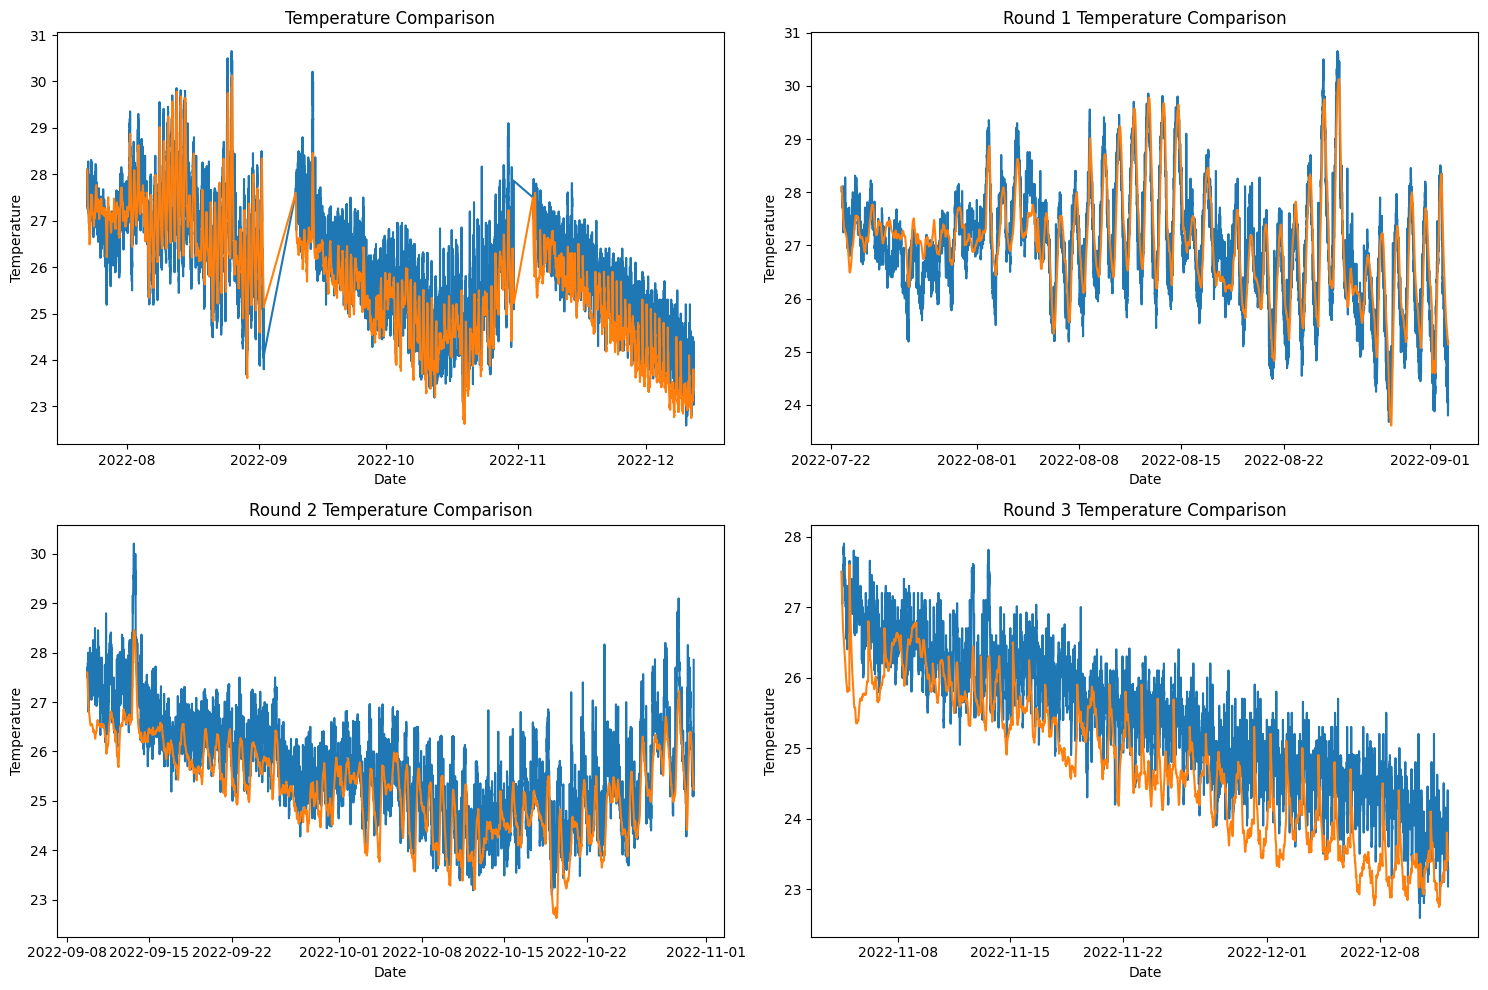

[0.42833680095375465, 0.283814963947009, 0.01680564095773655]


In [28]:
trend_plotter(train, 3.8775, 36.609, 4.303, 33.426, 0.027303, 1,round = 0)

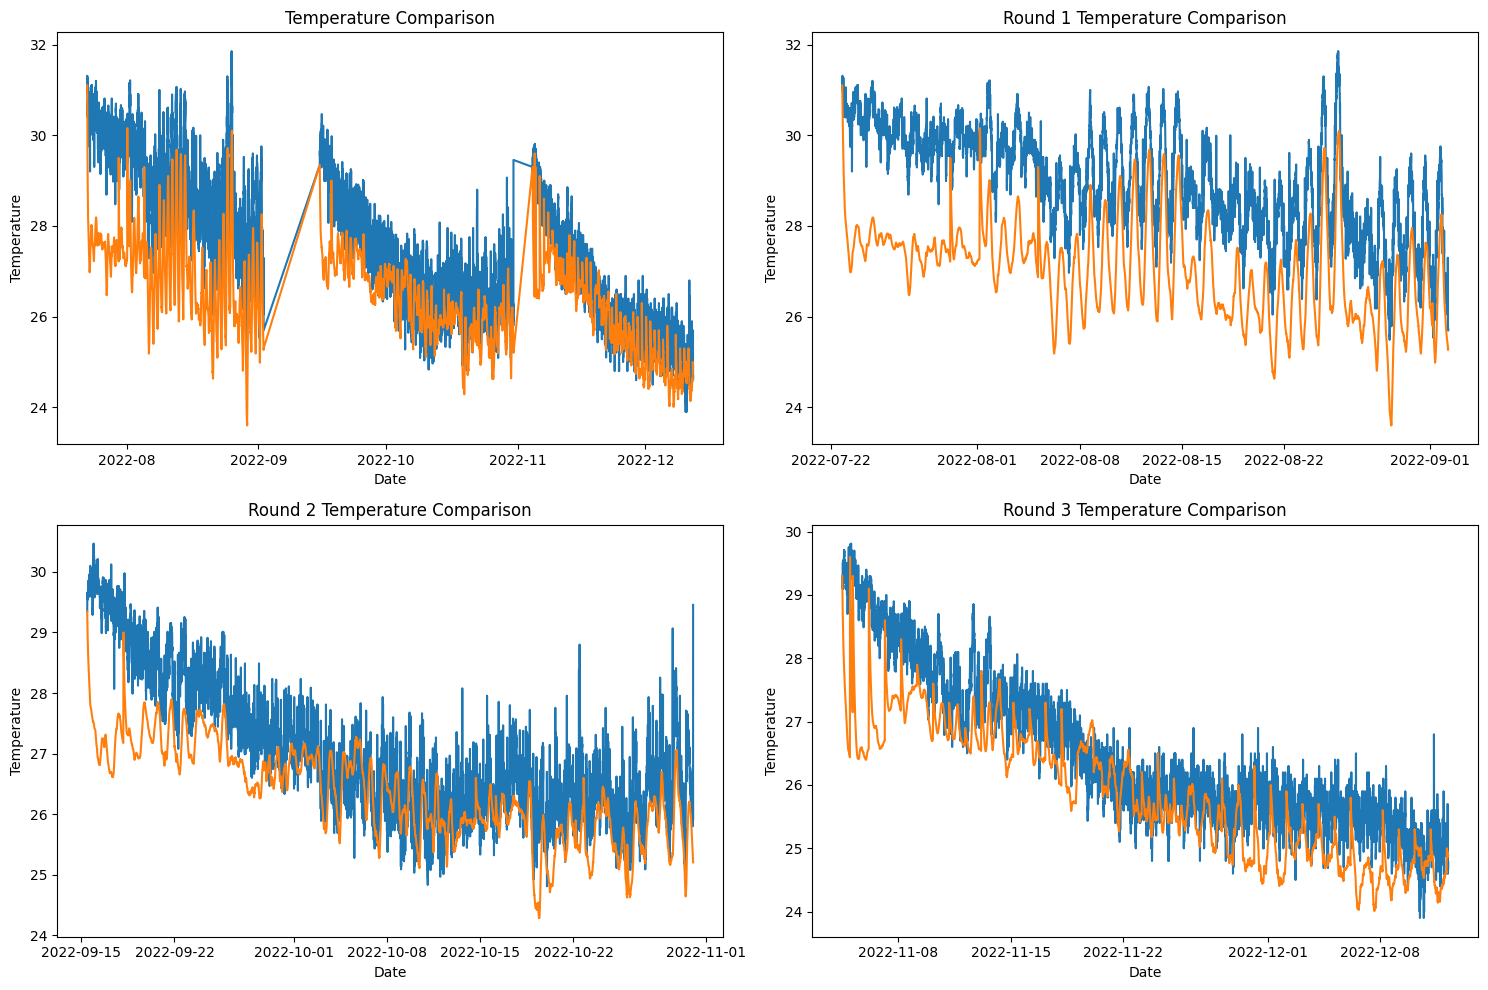

[0.8690877857529004, 0.7255658927079554]


In [81]:
trend_plotter(ctrl,  3.8775e+00,  3.6609e+01,  4.3030e+00,  3.3426e+01, 2.7303e-02, 1,round = 0)


In [83]:
def components(df, k, k1, Ks_L, h_g, pr, kv):
    df["qv"] = np.nan
    df['qh2'] = np.nan
    df["qh"] = np.nan
    df['qfh'] = Qfh(df['Inside temperature'], df['floor_temp'], h_g)
    df['qe'] = Qe(df['Inside temperature'], df['T- Inlet behind conditioner'], Ks_L)
    df['qp'] = Qp(df['Qpig'], df['T- Inlet behind conditioner'])
    df['qr'] = Qr(df['Id_areahit'], pr)

    for index, row in df.iterrows():
        air_dens = calculate_air_density(row['humidity'], row['Inside temperature'])
        heat_cap = calculate_specific_heat_capacity(row['humidity'])
        
        df.at[index, 'qh'] = Qh_(heat_cap,k, row['T- Inlet behind conditioner'])
        df.at[index, 'qh2'] = Qh2_(k1, row['T- Inlet behind conditioner'])
        df.at[index, 'qv'] = Qv(row['humidity'], row['Current ventilation'],row['Inside temperature'], row['T- Inlet behind conditioner'])*kv


In [84]:
def plotter(df):
    qh_values = df['qh']
    qv_values = df['qv']
    qe_values = df['qe']
    qp_values = df['qp']
    qfh_values = df['qfh']
    qr_values = df['qr']

    # Create a time axis
    time = range(len(qh_values))

    # Plot the variables
    plt.plot(time, qh_values, label='qh')
    plt.plot(time, qv_values, label='qv')
    plt.plot(time, qe_values, label='qe')
    plt.plot(time, qp_values, label='qp')
    plt.plot(time, qfh_values, label='qfh')
    plt.plot(time, qr_values, label='qr')

    # Add labels and title
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('QH, QV, QE, QP, QFH')

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

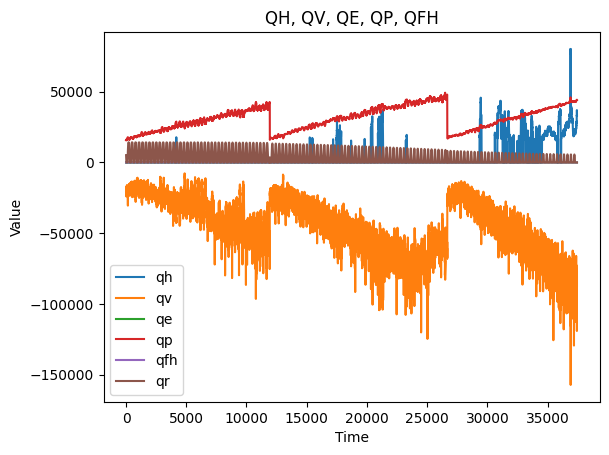

In [85]:
components(train,5.0171e+00,  7.0628e+00, 6.4424e-05, 6.3105e-05,  1.6566e-01,1)
plotter(train)


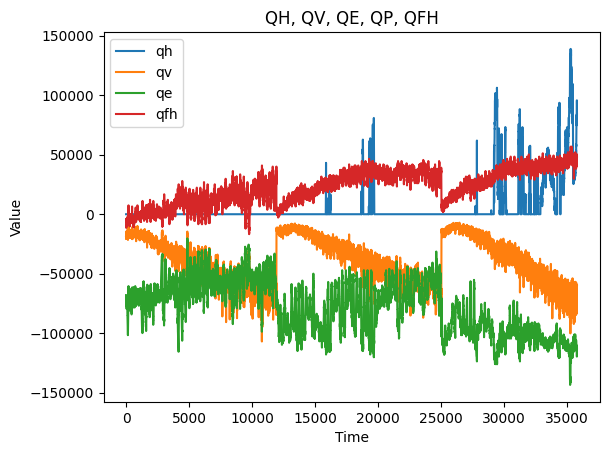

In [415]:
components(ctrl,0.8799, +0.1863, 10.6620, 30.9839, +0.4788, 1)
plotter(ctrl)

In [72]:
train.to_csv('Useful data/train_final3.csv', index=False)
ctrl.to_csv('Useful data/ctrl_final3.csv', index=False)